# About

In [13]:
# only for development, can be removed later
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Text about organization of our code and this notebook

# Prerequisites 

(tbd) This notebook assumes that you:

- have internet access
- have a Google identity
- have configured a project under Google Cloud Platform (you can see how to complete this step in this tutorial)
- replace ##MY_PROJECT_ID## in the cell below with the ID of the GCP project you have confugured under your account

In [2]:
my_project_id = "idc-pathomics-000"

# Environment setup

In [3]:
curr_dir = !pwd
curr_droid = !hostname
curr_pilot = !whoami

print("Current directory :", curr_dir[-1])
print("Hostname          :", curr_droid[-1])
print("Username          :", curr_pilot[-1])

Current directory : /home/jupyter/idc-pathomics-use-case-1/src
Hostname          : idc-patho-vm
Username          : jupyter


In [26]:
!sudo apt-get update
!sudo apt-get install --no-install-recommends -y python3-openslide
!sudo pip3 install -r ../requirements_cptac.txt # at the end, check whether all are required, maybe no requirement file needed, when only one/two things are installed
!pip install wandb -qqq # monitoring tool 

Hit:1 http://security.debian.org/debian-security buster/updates InRelease
Hit:2 http://deb.debian.org/debian buster InRelease                            
Hit:3 http://deb.debian.org/debian buster-updates InRelease                    
Hit:4 http://deb.debian.org/debian buster-backports InRelease                  
Hit:5 https://nvidia.github.io/libnvidia-container/stable/debian10/amd64  InRelease
Hit:6 https://download.docker.com/linux/debian buster InRelease                
Hit:7 https://nvidia.github.io/nvidia-container-runtime/stable/debian10/amd64  InRelease
Hit:8 https://nvidia.github.io/nvidia-docker/debian10/amd64  InRelease
Hit:9 http://packages.cloud.google.com/apt cloud-sdk-buster InRelease
Hit:11 https://packages.cloud.google.com/apt google-fast-socket InRelease
Hit:12 http://packages.cloud.google.com/apt google-cloud-packages-archive-keyring-buster InRelease
Get:10 https://packages.cloud.google.com/apt kubernetes-xenial InRelease [9383 B]
Hit:13 http://packages.cloud.google.c

In [27]:
# Import all required python libraries for this use case
import os
import sys
sys.path.append('/usr/local/lib/python3.7/dist-packages') # otherwise Openslide can not be loaded. Maybe find a better solution?!
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import wandb

In [6]:
# Create directories for input and output data 
input_dir = '/home/jupyter/idc_input/'
output_dir = '/home/jupyter/idc_output/'
os.mkdir(input_dir)
os.mkdir(output_dir)

FileExistsError: [Errno 17] File exists: '/home/jupyter/idc_input/'

# Dataset selection and exploration

IDC relies on the Google Cloud Platform (GCP) for storage and management of DICOM data. The data are contained in so-called [storage buckets](https://cloud.google.com/storage/docs/key-terms#buckets), from which they are available for the user on a [requester pays](https://cloud.google.com/storage/docs/requester-pays) basis. Currently, all pathology whole-slide images (WSI) are located in the `tbd` bucket.
**Metadata** for the DICOM files - including standard DICOM tags, but also non-DICOM metadata - are stored in BigQuery tables from which they can easily be accessed using standard SQL queries. This gives users the opportunity to explore available data by examining metadata without the need of downloading the DICOM data in the first place.

(How to find attributes we need?) 

(BigQuery magic, alternative: BigQuery client see https://cloud.google.com/bigquery/docs/visualize-jupyter?hl=de#pip) 

(Further information in IDC Documentation) 

(add project ID --> bigquery resultsa are stored in pandas dataframe) 

In [8]:
%%bigquery cohort_df --project=$my_project_id 

WITH slide_images AS (
    SELECT
        ContainerIdentifier AS slide_id,
        PatientID AS patient_id,
        ClinicalTrialProtocolID AS dataset,
        TotalPixelMatrixColumns AS width,
        TotalPixelMatrixRows AS height,
        gcs_url,
        CAST(SharedFunctionalGroupsSequence[OFFSET(0)].
             PixelMeasuresSequence[OFFSET(0)].
             PixelSpacing[OFFSET(0)] AS FLOAT64) AS pixel_spacing,
        CASE TransferSyntaxUID
            WHEN '1.2.840.10008.1.2.4.50' THEN 'jpeg'
            WHEN '1.2.840.10008.1.2.4.91' THEN 'jpeg2000'
            ELSE 'other'
        END AS compression
    FROM idc-dev-etl.idc_v3.dicom_all
    WHERE NOT (ContainerIdentifier IS NULL)
)
SELECT *
FROM slide_images
WHERE
    (compression = "jpeg")
    AND (dataset = "CPTAC-LUAD" OR dataset = "CPTAC-LSCC")
    -- pixel spacing between 0.00025 and 0.00051 mm corresponds to 20x magnification
    AND (pixel_spacing > 0.00025) AND (pixel_spacing < 0.00051)

Downloading: 100%|██████████| 2211/2211 [00:01<00:00, 1444.15rows/s]


Since up to now the information about the slide's tissue type (tumor tissue or normal tissue) is missing in the BQ table, we have to extract those from the attached TCIA metadata file and add them to our cohort's metadata. We remove slides that have no tissue type information available from our cohort. 

In [19]:
from data.utils import attach_tissue_type_information

tissue_type_data = pd.read_csv(os.path.join(input_dir, 'tissue_type_data_TCIA.csv'))
slides_metadata = attach_tissue_type_information(cohort_df, tissue_type_data)
slides_metadata_path = os.path.join(input_dir, 'slides_metadata.csv')
slides_metadata.to_csv(slides_metadata_path, index=False) # Save slides metadata as csv for later use

Using pandas and matplotlib functionality the user can have a look at the selected cohort's metadata and visualize some aspects of interest: 

In [18]:
print('Total number of slides in this cohort: ', len(slides_metadata))
nr_slides_from_luad_patients = slides_metadata.groupby('cancer_subtype').size()['luad'] # or len(slides_metadata[slides_metadata['cancer_subtype'] == 'luad']) 
nr_slides_from_lscc_patients = slides_metadata.groupby('cancer_subtype').size()['lscc'] # or len(slides_metadata[slides_metadata['cancer_subtype'] == 'lscc'])
nr_luad_patients = slides_metadata.drop_duplicates('patient_id').groupby('cancer_subtype').size()['luad']
nr_lscc_patients = slides_metadata.drop_duplicates('patient_id').groupby('cancer_subtype').size()['lscc']
print('--> %d slides from %d LUAD patients' %(nr_slides_from_luad_patients, nr_luad_patients))
print('--> %d slides from %d LSCC patients' %(nr_slides_from_lscc_patients, nr_lscc_patients))

slides_metadata.head()

Total number of slides in this cohort:  2129
--> 1056 slides from 229 LUAD patients
--> 1073 slides from 211 LSCC patients


,slide_id,patient_id,cancer_subtype,tissue_type,width,height,gcs_url,pixel_spacing,compression
0,93e30fd5-e57e-4503-a175-863c7d_D1_D1,11LU016,luad,tumor,55775,48446,gs://idc_dev/51036e43-5622-41a9-af03-603cf2127...,0.000494,jpeg
1,C3L-00095-26,C3L-00095,luad,normal,27887,24718,gs://idc_dev/72cf9b5f-d467-4a86-9fc6-b9272cc42...,0.000494,jpeg
2,C3L-00412-21,C3L-00412,luad,tumor,33863,32867,gs://idc_dev/54fa081e-e62e-4df2-8f0f-5bd1424d4...,0.000494,jpeg
3,C3L-00568-23,C3L-00568,lscc,tumor,19919,18390,gs://idc_dev/80ec2c0e-e246-4a0d-bfcb-3c3d5f31c...,0.000494,jpeg
4,C3L-00893-21,C3L-00893,luad,tumor,19919,19138,gs://idc_dev/bd709e68-45be-4059-944a-4a42fa096...,0.000494,jpeg


In [ ]:
# Distribution of slides and patients


cancer_subtype  tissue_type
lscc            normal         384
                tumor          689
luad            normal         378
                tumor          678
dtype: int64


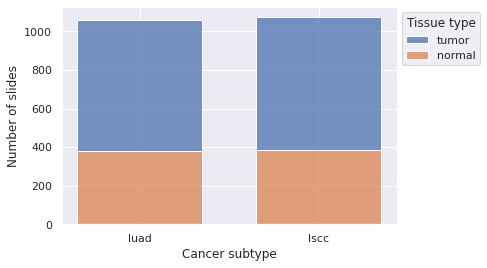

In [69]:
# Displaying tissue type distribution
print(slides_metadata.groupby(['cancer_subtype', 'tissue_type']).size())
ax = sns.histplot(slides_metadata, x='cancer_subtype', hue='tissue_type', multiple='stack', shrink=0.7)
ax.set_xlabel('Cancer subtype')
ax.set_ylabel('Number of slides')
legend = ax.get_legend()
legend.set_title('Tissue type')
legend.set_bbox_to_anchor((1, 1))

Text(0, 0.5, 'Number of patients')

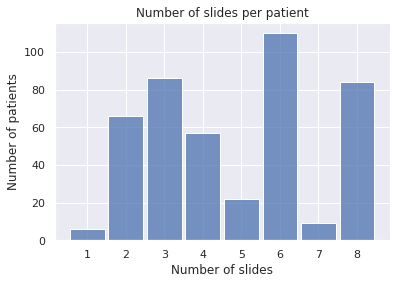

In [67]:
# How many slides per patient?
slides_per_patient = slides_metadata.groupby(['patient_id']).size()
ax2 = sns.histplot(slides_per_patient, discrete=True, shrink=0.9)
ax2.set_title('Number of slides per patient')
ax2.set_xlabel('Number of slides')
ax2.set_ylabel('Number of patients')

In [ ]:
# IDC viewer for some pathomics data? 
def get_idc_viewer_url(study_UID):
    return "https://viewer.imaging.datacommons.cancer.gov/viewer/" + study_UID

# Pathomics use case

Text about experiments we are going to perfom 

## Preprocessing

In [22]:
from data.tile_generation_cptac import generate_tiles

slides_dir = os.path.join(input_dir, 'cptac_slides')
tiles_dir = os.path.join(input_dir, 'cptac_tiles')
#os.makedir(slides_dir)
#os.makedir(tiles_dir)

#generate_tiles(slides_dir, os.path.join(input_dir, 'slides_metadata.csv'), tiles_dir, 'idc-pathomics-000')

#os.remove(slides_dir) # delete because this directory is now empty and no longer required

In [24]:
from data.tile_sorting_cptac import sort_tiles

sort_tiles(tiles_dir, slides_metadata_path, input_dir, 'norm_cancer')
sort_tiles(tiles_dir, slides_metadata_path, input_dir, 'luad_lscc')
sort_tiles(tiles_dir, slides_metadata_path, input_dir, 'norm_luad_lscc')

## Training

In [32]:
wandb.login()
run = wandb.init()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


2021-08-09 14:59:02.756046: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2021-08-09 14:59:03.747571: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libnvinfer.so.7
2021-08-09 14:59:03.748784: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libnvinfer_plugin.so.7



InvalidVersionSpec: Invalid version '1.0<2': invalid character(s)



In [33]:
from data.data_set import Dataset
from model.inceptionv3_model import InceptionModel

output_dir_experiment = os.path.join(output_dir, time.strftime("%Y%m%d_%H%M%S"))
os.mkdir(output_dir_experiment)

dataset_train = Dataset(os.path.join(input_dir, 'train_norm_luad_lscc.csv'), num_classes=3)
dataset_valid = Dataset(os.path.join(input_dir, 'valid_norm_luad_lscc.csv'), num_classes=3)
model = InceptionModel(num_classes=3, input_shape=(128,128,3), learning_rate=0.01)
#print(model)

model.train(dataset_train, batch_size=64, epochs=10, output_path=output_dir_experiment, validation_dataset=dataset_valid)
model.save(output_dir_experiment)
# how to select best model or simply take final model here? 

Train for 38962 steps, validate for 557456 steps
Epoch 1/10
 2304/38962 [>.............................] - ETA: 5:16:42 - loss: 0.7570 - auc_1: 0.8557

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_v2.py", line 767, in on_epoch
    yield epoch_logs
  File "/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_v2.py", line 342, in fit
    total_epochs=epochs)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_v2.py", line 128, in run_one_epoch
    batch_outs = execution_function(iterator)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_v2_utils.py", line 98, in execution_function
    distributed_function(input_fn))
  File "/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/eager/def_function.py", line 568, in __call__
    result = self._call(*args, **kwds)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/eager/def_function.py", line 599, in _call
    return self._stateless_fn(*args, **kwds)  # pylint: disable=no

TypeError: object of type 'NoneType' has no len()

In [35]:
run.finish()

## Evaluation

In [ ]:
from evaluation.predictions import Predictions

test_dataset = Dataset(os.path.join(input_dir, 'csv_test_mutations_split1_egfr.csv'), num_classes=2)
predictions = Predictions(model, test_dataset) 
predictions.save(os.path.join(output_dir, commit, 'predictions_testset_epoch28.json'))

In [ ]:
from evaluation.roc import ROCAnalysis

roc_analysis = ROCAnalysis(predictions, experiment='binary_egfr')
roc_analysis.plot(os.path.join(output_dir, commit)) # make an inline plot
roc_analysis.print_and_save_tabluar_results(os.path.join(output_dir, commit, 'results_table_testset_epoch28.html'))

In [ ]:
from evaluation.heatmap import Heatmap 

colormaps=['coolwarm', 'coolwarm', 'coolwarm']
hm = Heatmap(predictions, 'TCGA-68-8250-01A-01-TS1.d6347fc6-c657-4d0f-bba9-09efde4991f3', colormaps)
hm.plot(os.path.join(output_dir, commit, 'heatmap.png'))

## Notes for improvement
- vielleicht ueberall funktionsparameter benennen zur besseren verstaendlichkeit**
- when displaying attributes of the dataset explain that from all patients we have healthy and tumor slide. 
- where to explain that we use gcl_url to download slides and tile them then? 